# Prepare Dataset: Compute Stats and Normalize
> Compute dataset statistics, normalize and clean raw datasets and save them as new `.npy` pickle files

Load a raw dataset, then
1. Compute dataset stats and write it to `./data_stats.csv`.
    - Read/import it as `pd.read_csv('./data_stats.csv',header=0,index_col=0)`
1. Normalize raw dataset with given mean/median and scale.
    - e.g. for lab2 in autocaffe we use data stat-s after interpolation.
1. Save normalized datasets as `./train_norm.npy` and `./test_norm.npy`
    - You can later load them with numpy, e.g.
    ```python
    with open('train_norm.npy', 'rb') as f:
        train_norm = np.load(f)
    ```
1. Obtain persistence loss (for normalized data with MSE loss, or any other loss that you set)
    - note that session 5 uses MSE loss and an additional factor of 0.5x for persistence loss ([_see video_](https://youtu.be/TSHc60ZI7cU?t=268))
    - save it to `./persistence_T{}.npy` where `{}` is replaced by the lead time, e.g. `./persistence_T5.npy`.
    - You can load it back with the code below:
```python
with open('persistence_T5.npy','rb') as f:
    x=np.load(f,allow_pickle=True).item()
```
`x` is a python `dict` object.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

In [ ]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,6)
# matplotlib.rcParams['font.size']= 22 # use for presentation
pd.options.mode.chained_assignment = None

In [ ]:
# df = pd.read_csv('/Users/muratshagirov/Downloads/angerville-1.csv',header=3,index_col=0)
# df

## Load Raw Dataset

(876, 1)
0    float64
dtype: object


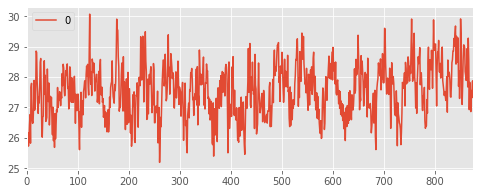

In [ ]:
# read the data
df = pd.read_csv('../../datathon2020/NN102/sg_temps/sg_temps_raw.csv',header=None)

# shape and data types of the data
print(df.shape)
print(df.dtypes)
df.plot(label='raw',figsize=[8,3]);

In [ ]:
df.head()

,0
0,26.336905
1,25.832143
2,26.165476
3,25.728571
4,25.964286


## Compute Raw Data Stats, and Handling Missing data
- FOR MISSING DATA, uncomment and edit cells below. Data stats are computed after handling missing data (or whichever way it was agreed by all team members).
- Compute stat-s and later write them to `./raw_data_stats.csv`,
- Handle missing data. E.g. interpolate, then save stats to `./interp_data_stats.csv`.

---

- raw data before interpolation

In [ ]:
raw_data_stats = {}
indx = ['min','max','mean','median','std','range']
raw_data_stats['raw'] = [df.values.min(), df.values.max(),
                     df.values.mean(), np.median(df.values),
                     df.values.std(), df.values.max() - df.values.min() ]

# write to file
raw_data_stats_df  = pd.DataFrame(data=raw_data_stats,index=indx)
raw_data_stats_df.to_csv('./raw_data_stats.csv',
                     header=True,index=True)

print('Raw dataset statistics:')
raw_data_stats_df

Raw dataset statistics:


,raw
min,25.192857
max,30.064286
mean,27.552222
median,27.549405
std,0.841899
range,4.871429


### Handle missing data

In [ ]:
# # sort by date & time
# df['Datetime'] = pd.to_datetime(df['Datetime'])
# df.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
# df.reset_index(inplace=True, drop=True)

# # renaming the target variable columns
# df.rename(columns={'PJM_Load_MW':'demand_in_MW'}, inplace=True)

# # display the first couple of rows
# df.head()

In [ ]:
# # let's see if we have a continuous dataset
# df = df.set_index('Datetime')
# print(f'df.index.freq is set to: {df.index.freq}')

In [ ]:
# date_range = pd.date_range(df.index[0],df.index[-1],freq='H')
# print(f'The difference in length between the custom date range and our dataset is {(len(date_range)-len(df))}:')
# print(date_range.difference(df.index))

In [ ]:
# ax=df.plot(style='-',alpha=.5,figsize=[12,5])
# ax.set_ylabel('Hrly Demand (MW)')
# ax.set_xlabel('Time')
# ax.vlines(date_range.difference(df.index),20000,50000,'k')
# plt.show()

- Interpolate missing values

In [ ]:
# print(f'--> # of timeseries samples before interpolation:{len(df)}')
# # this will append the previously missing datetimes, and create null values in our target variable
# df = df.reindex(date_range)

# # we fill in the blanks with values that lie on a linear curve between existing data points
# df['demand_in_MW'].interpolate(method='linear', inplace=True)

# # now we have a neatly continuous datetime index
# print(f'The df.index.freq is now: {df.index.freq}, indicating that we no longer have missing instances')
# print(f'--> # of timeseries samples after interpolation:{len(df)}')

- Stat-s after interpolation

In [ ]:
# interp_data_stats['after_interp'] = [df.values.min(), df.values.max(),
#                               df.values.mean(), np.median(df.values),
#                               df.values.std(), df.values.max() - df.values.min() ]

# # write to file
# interp_data_stats_df  = pd.DataFrame(data=interp_data_stats,index=indx)
# interp_data_stats_df.to_csv('./interp_data_stats.csv',
#                      header=True,index=True)

# print('Dataset statistics:')
# interp_data_stats_df

- E.g. for lab2 in autocaffe we use data stat-s _after_ interpolation

## Normalise Dataset and Save to File
1. Normalise dataset using raw dataset stats, or in case of missing values after intepolating missing data points (depends on what team decides).
1. To normalise all values, we use agreed upon standard scales, e.g. mean $\mu$ and $\sigma$:
$$x_{normalized} = \frac{x_{raw}-\mu}{\sigma}$$
1. Compute Persistence `T+lag_time` for the normalised data
1. Later, split normalized dataset into training and testing datasets, and then save them to use it later:
    - E.g. 70/30 split: where we use the 1st 70% as training data, and the remaining examples as test data. (w/o losing any examples)
    - Save normalized trainig and test datasets into `./train_norm.npy` and `./test_norm.npy`

### Normalize the Raw or  Interpolated Data

In [ ]:
# Shift data with mean or median
shift_ = 28.0 # e.g. mean , lookup from stats, you can round it up
scale_ = 0.8 # e.g. S.D., lookup from stats
data_norm = (df.values - shift_)/scale_

- write normalized dataset (full, we have not yet split it)

In [ ]:
# normalized training dataset:
with open('sg_temps.npy', 'wb') as f:
    np.save(f, data_norm)
# to CSV
data_norm_df = pd.DataFrame(data=data_norm)
data_norm_df.to_csv('sg_temps.csv',header=False,index=False)

Norm-d data:
mean: -0.559722562114726
std: 1.052374024478898
median:-0.5632440500000002


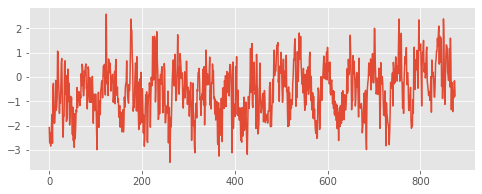

In [ ]:
print(f'Norm-d data:\nmean: {data_norm.mean()}\n'+
     f'std: {data_norm.std()}\nmedian:{np.median(data_norm)}')
plt.figure(figsize=[8,3])
plt.plot(data_norm);

## Persistence Loss (for Normalized Data with MSE loss)

- Autocaffe videos use "Euclidean Loss" from Caffe 1.0, which is `0.5*MSE`
- note that session 5 uses MSE loss and an additional factor of 0.5x for persistence loss ([_see video_](https://youtu.be/TSHc60ZI7cU?t=268))
---
Compute persistence loss and save it to `./persistence_T{}.npy` where `{}` is replaced by the lead time, e.g. `./persistence_T5.npy`.
- You can load it back with the code below:
```python
with open('persistence_T5.npy','rb') as f:
    x=np.load(f,allow_pickle=True).item()
```
`x` is a python `dict` object.
- Here, `persistence` is computed starting from the first elements of `train_norm` (or `test_norm`). Your exact training/testing dataset will start from the last element in the window, which will be set as first $Y(T+0)$.

In [ ]:
from src.utils import persistence_loss

In [ ]:
Tlead = 7
# utils.persistence_loss by default uses MSE as metric
persistence_data = np.array({'lead_time':Tlead,
                             f'Persistence_Euclidean':
                             persistence_loss(data_norm,lead_time=Tlead,metric='euclidean'),
                             f'Persistence_MSE':
                             persistence_loss(data_norm,lead_time=Tlead)})

with open(f'persistence_T{Tlead}.npy', 'wb') as f:
    np.save(f,persistence_data)

# persistence_data = persistence_data.item()
print('Persistence T+{}\n---\nAutocaffe\'s metric (Euclidean loss): {}\nMSE loss: {}\n'.format(
    Tlead,persistence_data.item()['Persistence_Euclidean'],persistence_data.item()['Persistence_MSE']) )

Persistence T+7
---
Autocaffe's metric (Euclidean loss): 0.7410763587313423
MSE loss: 1.4821527174626845



### Plot Test/Train

In [ ]:
split_index = data_norm.shape[0]*70//100
train_norm = data_norm[:split_index]
test_norm = data_norm[split_index:]
print(f'data_norm.shape[0]== train_norm.shape[0]+test_norm.shape[0]: {data_norm.shape[0]== train_norm.shape[0]+test_norm.shape[0]}')

data_norm.shape[0]== train_norm.shape[0]+test_norm.shape[0]: True


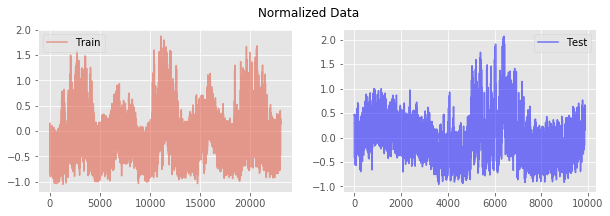

In [ ]:
# For presentation:
# with plt.rc_context({'font.size': 22}):
#     _,axs = plt.subplots(ncols=2,nrows=1,figsize=[20,5])
#     axs[0].plot(train_norm,label='Train',alpha=.5)
#     axs[1].plot(test_norm,color='b',label='Test',alpha=.5)
#     for k in range(axs.shape[0]):
#         axs[k].legend()
#     plt.suptitle('Normalized Data');
_,axs = plt.subplots(ncols=2,nrows=1,figsize=[10,3])
axs[0].plot(train_norm,label='Train',alpha=.5)
axs[1].plot(test_norm,color='b',label='Test',alpha=.5)
for k in range(axs.shape[0]):
    axs[k].legend()
plt.suptitle('Normalized Data');

### Histograms:

In [ ]:
# Number of bins:
N_bins = 50
# histogram range:
x_range = [min([train_norm.min(),test_norm.min()]),
           max([train_norm.max(),test_norm.max()])]
hist_bins = np.linspace(x_range[0],x_range[1],N_bins)

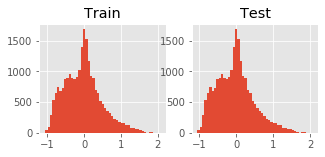

In [ ]:
# # For presentation:
# with plt.rc_context({'font.size': 22}):
#     _, axs = plt.subplots(nrows=1,ncols=2,figsize=[15,5],sharex=True,squeeze=True)
#     # Train
#     axs[0].hist(train_norm, bins=hist_bins)
#     axs[0].set_title('Train')
#     # Test
#     axs[1].hist(test_norm, bins=hist_bins)
#     axs[1].set_title('Test')
#     plt.show()
_, axs = plt.subplots(nrows=1,ncols=2,figsize=[5,2],sharex=True,squeeze=True)
# Train
axs[0].hist(train_norm, bins=hist_bins)
axs[0].set_title('Train')
# Test
axs[1].hist(train_norm, bins=hist_bins)
axs[1].set_title('Test')
plt.show()

---
Difference $Y(T+1)-Y(T+0)$ for normalized data:

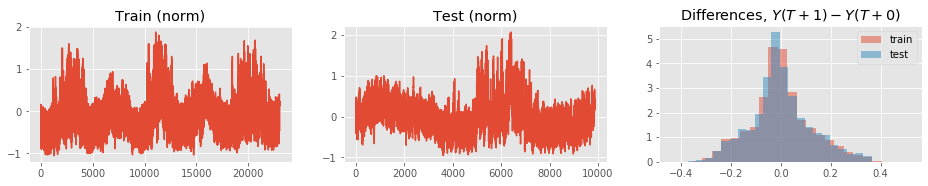

In [ ]:
_,axs = plt.subplots(ncols=3,nrows=1,figsize=[16,2.5],squeeze=True)
# Plot time series
axs[0].plot(train_norm)
axs[0].set_title('Train (norm)')
axs[1].plot(test_norm)
axs[1].set_title('Test (norm)')
# deltaY: differences Y(t+1)-Y(t)
axs[2].hist((train_norm[1:]-train_norm[:-1]),bins=25,density=True,alpha=.5,label='train')
axs[2].hist(test_norm[1:]-test_norm[:-1],bins=25,density=True,alpha=.5,label='test')
plt.title('Differences, $Y(T+1)-Y(T+0)$')
plt.legend()
plt.show()

---

- What do we know about the dataset, e.g. how is it generated? any regularities?
- Note the sharp peak near zero for Y difference data

---

## Write Normalized Train/Test Datasets to New Files

- Write arrays to `./train_norm.npy` and `./test_norm.npy`

In [ ]:
# normalized training dataset:
with open('train_norm.npy', 'wb') as f:
    np.save(f, train_norm)

# normalized test dataset:
with open('test_norm.npy', 'wb') as f:
    np.save(f, test_norm)
    
# # For loading them back use:
# # with open('train_norm.npy', 'rb') as f:
# #    x_test = np.load(f)

```python
X = windowed_data(x_norm, lead_time=lead_time, window_size=window_size)
X_new = np.zeros((1,1),dtype=D1.dtype)
np.diff(X, n=n,axis=axis)
X[:,2:] = X[:,1:-1]-X[:,2:]
# concatenate Y(T+lead_time), Y(T+0), differences
```